# Assigment 3

##### Name: Jaimis Arvindbhai Miyani
    
##### Student ID: 400551743
    
##### MacID: miyanij@mcmaster.ca
    
##### Subject: SEP 775 - Introduction to Computational Natural Language Processing

# TANDA Approach for QA System Enhancement
### Objectives:
Explore TANDA (Transfer And Adapt) methodology to improve Question-Answering (QA) systems using pre-trained Transformer models, focusing on sequential fine-tuning te- chniques.

### 1. Preparation and Dataset Understanding


In [1]:
# Import necessary libraries

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from datasets import load_dataset

# Loading dataset
asnq_dataset = load_dataset('asnq')

asnq_data = pd.DataFrame(asnq_dataset['train'][:5000])
asnq_data = asnq_data.rename(columns={'sentence': 'answer'})

asnq_data.head()

,question,answer,label,sentence_in_long_answer,short_answer_in_sentence
0,what is the use of fn key in mac,It is typically found on laptops due to their ...,0,False,False
1,when did the ipod 7th generation come out,"Cupertino , California : Apple .",0,False,False
2,who dies in season 6 once upon a time,"^ Jump up to : Abrams , Natalie ( August 5 , 2...",0,False,False
3,who was the first avatar ever in the last airb...,Jeremy Zuckerman and Benjamin Wynn composed th...,0,False,False
4,how many games do they need to win to win the ...,p. 21 .,0,False,False


In [6]:
wikiqna_df = pd.read_csv('WikiQnA.tsv', sep='\t')
wikiqna_df = wikiqna_df.rename(columns={'SentenceID': 'AnswerId'})
wikiqna_df = wikiqna_df.rename(columns={'Sentence': 'Answer'})


In [7]:
wikiqna_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,AnswerId,Answer,Label
0,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-0,African immigration to the United States refer...,0
1,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-1,The term African in the scope of this article ...,0
2,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-2,From the Immigration and Nationality Act of 19...,0
3,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-3,African immigrants in the United States come f...,0
4,Q0,HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US,D0,African immigration to the United States,D0-4,"They include people from different national, l...",0


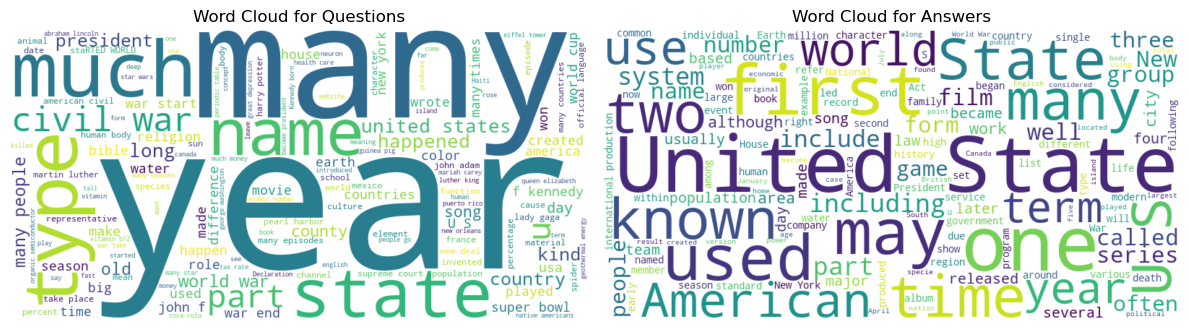

In [10]:
# Ploting word cloud for Questions and Answers for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt


plt.style.use('default')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud_question = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(wikiqna_df['Question']))
plt.imshow(wordcloud_question, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')

plt.subplot(1, 2, 2)
wordcloud_answer = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(' '.join(wikiqna_df['Answer']))
plt.imshow(wordcloud_answer, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')

plt.tight_layout()
plt.show()

In [11]:
# Printing shape of dataset
wikiqna_df.shape

(29208, 7)

In [12]:
# Printing information about the dataset
wikiqna_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29208 entries, 0 to 29207
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   QuestionID     29208 non-null  object
 1   Question       29208 non-null  object
 2   DocumentID     29208 non-null  object
 3   DocumentTitle  29208 non-null  object
 4   AnswerId       29208 non-null  object
 5   Answer         29208 non-null  object
 6   Label          29208 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [13]:
# Printing summary statistics of numerical columns
wikiqna_df.describe()

,Label
count,29208.000000
mean,0.050294
std,0.218556
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [14]:
# Checking for missing values
missing_values = wikiqna_df.isnull().sum()
print(f"Missing Values:\n{missing_values}")

Missing Values:
QuestionID       0
Question         0
DocumentID       0
DocumentTitle    0
AnswerId         0
Answer           0
Label            0
dtype: int64


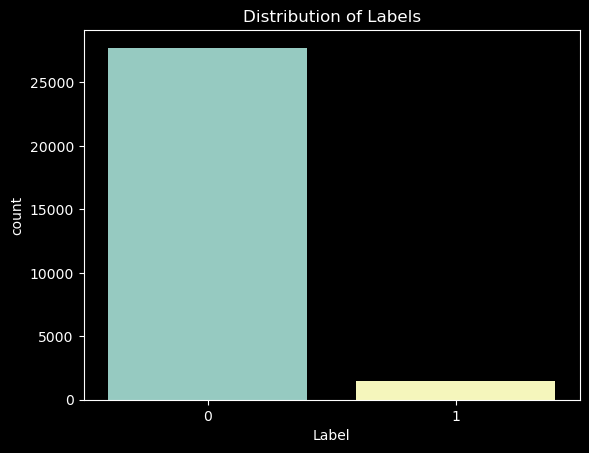

In [15]:
# Ploting distribution of labels
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

sns.countplot(x='Label', data=wikiqna_df)
plt.title('Distribution of Labels')
plt.show()

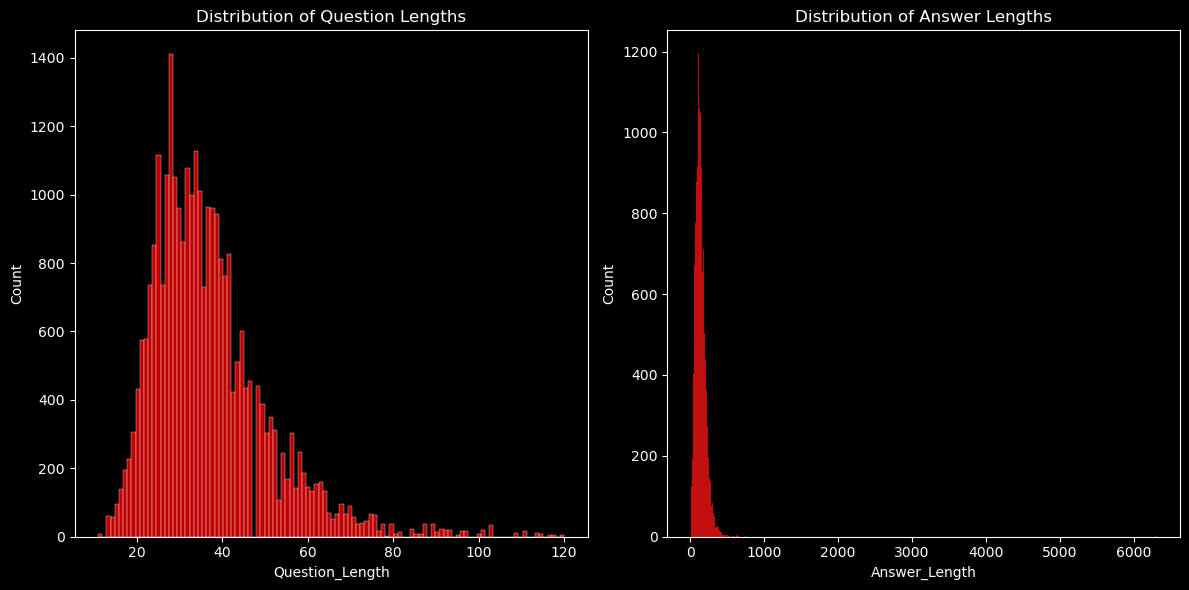

In [16]:
# Ploting distribution of question and answer lengths for visualization
import numpy as np

wikiqna_df['Question_Length'] = wikiqna_df['Question'].apply(len)
wikiqna_df['Answer_Length'] = wikiqna_df['Answer'].apply(len)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(wikiqna_df['Question_Length'], color='r')
plt.title('Distribution of Question Lengths')

plt.subplot(1, 2, 2)
sns.histplot(wikiqna_df['Answer_Length'], color='r')
plt.title('Distribution of Answer Lengths')

plt.tight_layout()
plt.show()

#### To embed the Question and Answer field, it's necessary to pad the text sequences. Therefore, the distributions of Answer and Question lengths are crucial factors in determining the appropriate padding length.

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimismiyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jaimismiyani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


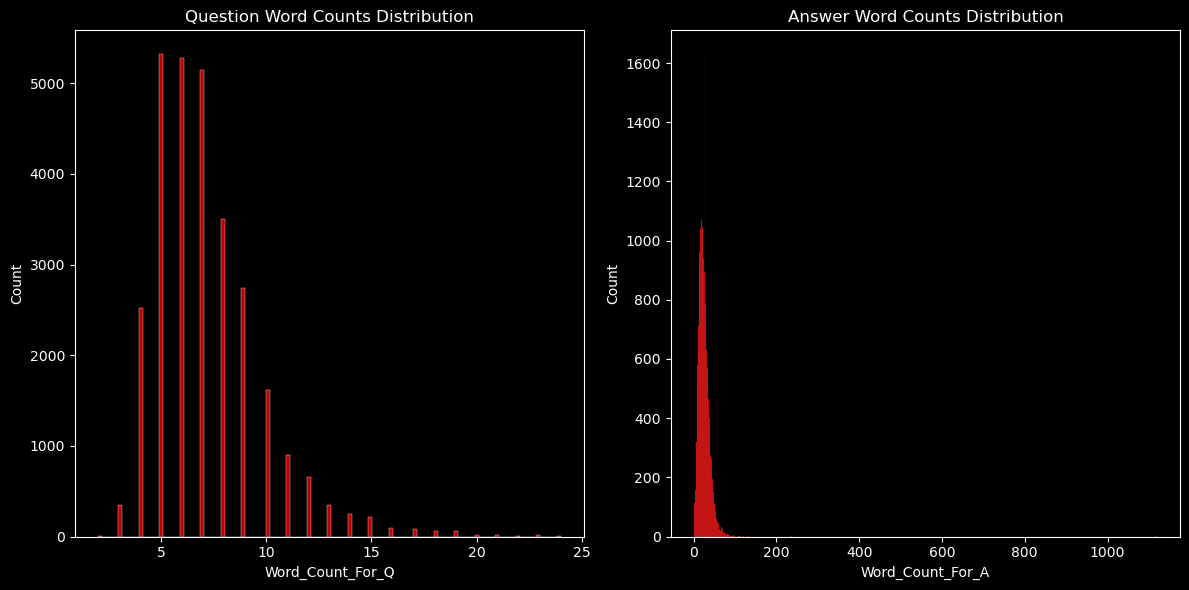

In [17]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Ploting word count distribution for Questions and Answers for visualization 
wikiqna_df['Word_Count_For_Q'] = wikiqna_df['Question'].apply(lambda x: len(word_tokenize(str(x))))
wikiqna_df['Word_Count_For_A'] = wikiqna_df['Answer'].apply(lambda x: len(word_tokenize(str(x))))

# Distribution of word counts for Questions and Answers
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(wikiqna_df['Word_Count_For_Q'], color='r')
plt.title('Question Word Counts Distribution')

plt.subplot(1, 2, 2)
sns.histplot(wikiqna_df['Word_Count_For_A'], color='r')
plt.title('Answer Word Counts Distribution')

plt.tight_layout()
plt.show()

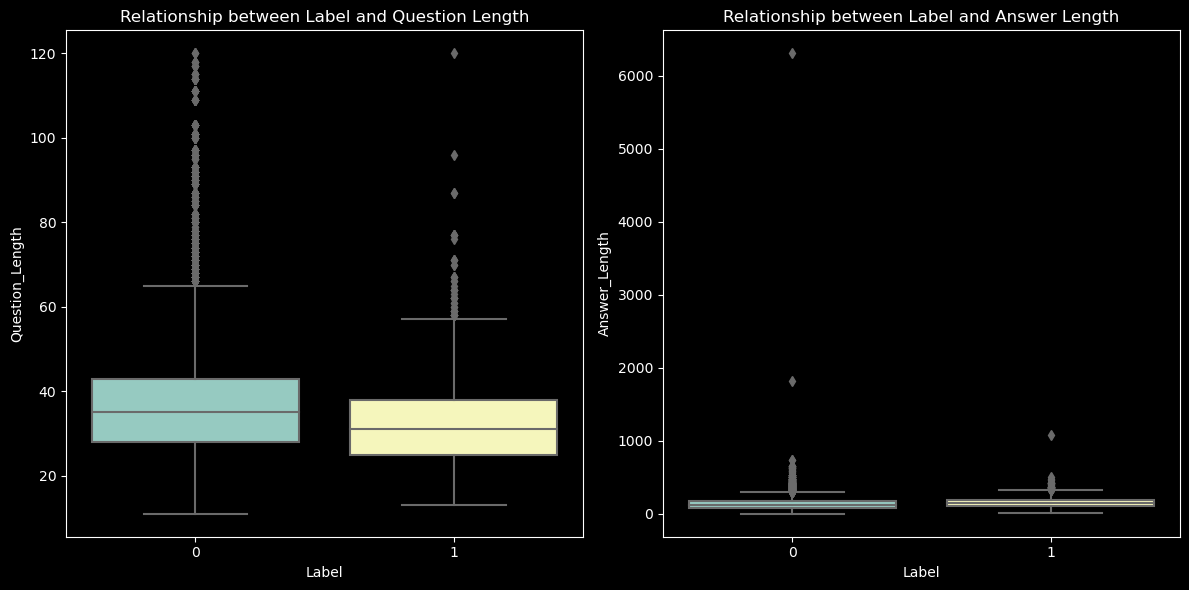

In [18]:
# Exploring relationships between features and labels
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Label', y='Question_Length', data=wikiqna_df)
plt.title('Relationship between Label and Question Length')

plt.subplot(1, 2, 2)
sns.boxplot(x='Label', y='Answer_Length', data=wikiqna_df)
plt.title('Relationship between Label and Answer Length')

plt.tight_layout()
plt.show()

### 2. Model Implementation

In [19]:
# Importing necessary libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel  

In [20]:
# Defining Transformer-based model
class MyTransformerModel(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(MyTransformerModel, self).__init__()
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        output = self.fc(outputs['last_hidden_state'][:, 0, :])
        return output

In [21]:
# Defining custom dataset
class MyDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.data[idx], truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {'input_ids': encoding['input_ids'].squeeze(), 'attention_mask': encoding['attention_mask'].squeeze(), 'label': torch.tensor(self.labels[idx])}

In [22]:
# Function for training
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [23]:
# Function for evaluation
def evaluate(model, dataloader, criterion):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [26]:
# Implementing model
input_dim = 768  # Dimension of the transformer output
output_dim = 2  # Assuming a binary classification task
model = MyTransformerModel(input_dim, output_dim)

# Experimental setup and evaluation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128 

asnq_dataset = MyDataset(asnq_data['question'] + ' ' + asnq_data['answer'], asnq_data['label'], tokenizer, max_length)
domain_dataset = MyDataset(wikiqna_df['Question'][:4000] + ' ' + wikiqna_df['Answer'][:4000], wikiqna_df['Label'][:4000], tokenizer, max_length)

batch_size = 32  
asnq_dataloader = DataLoader(asnq_dataset, batch_size=batch_size, shuffle=True)
domain_dataloader = DataLoader(domain_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 8

for epoch in range(num_epochs):
    # Baseline model training on ASNQ dataset
    train_loss = train(model, asnq_dataloader, criterion, optimizer)

    # TANDA model sequential fine-tuning
    # 1. Fine-tune on ASNQ dataset
    train_loss_asnq = train(model, asnq_dataloader, criterion, optimizer)
    # 2. Adapt to domain-specific dataset
    train_loss_domain = train(model, domain_dataloader, criterion, optimizer)

    # Evaluating both models
    asnq_accuracy = evaluate(model, asnq_dataloader, criterion)
    domain_accuracy = evaluate(model, domain_dataloader, criterion)

    print(f'Epoch {epoch + 1}: ASNQ Loss = {train_loss_asnq}, ASNQ Accuracy = {asnq_accuracy}')
    print(f'Epoch {epoch + 1}: Domain Loss = {train_loss_domain}, Domain Accuracy = {domain_accuracy}\n\n')


Epoch 1: ASNQ Loss = 0.021678369164428255, ASNQ Accuracy = 0.9982
Epoch 1: Domain Loss = 0.2056917833504045, Domain Accuracy = 0.955
Epoch 2: ASNQ Loss = 0.01474921088472934, ASNQ Accuracy = 0.9982
Epoch 2: Domain Loss = 0.19107786493648768, Domain Accuracy = 0.955
Epoch 3: ASNQ Loss = 0.015168146665679264, ASNQ Accuracy = 0.9982
Epoch 3: Domain Loss = 0.1884550330626547, Domain Accuracy = 0.955
Epoch 4: ASNQ Loss = 0.014691788412442959, ASNQ Accuracy = 0.9982
Epoch 4: Domain Loss = 0.1883963559677077, Domain Accuracy = 0.955
Epoch 5: ASNQ Loss = 0.021170495421986322, ASNQ Accuracy = 0.9982
Epoch 5: Domain Loss = 0.1851002353059638, Domain Accuracy = 0.955
